### Topic: HR Analytics: Job Change of Data Scientists

Problem: A company which is active in Big Data and Data Science wants to hire data scientists among people who successfully pass some courses which conduct by the company. Many people signup for their training.

Goal: Company wants to know which of these candidates are really wants to work for the company after training or looking for a new employment. Which features predict how many hours of training are going to be spent? Does it make 
sense to hire a candidate with more experience/salary (less training hours) or investing in unexperienced candidate.

Purpose: 
1. Reduce the cost and time for training
2. Information about quality of training or planning the courses and categorization of candidates

Ideas: Comparing costs for training (measured per hr) and salary (measured on yrs of experience). Is it better to hire someone with more experiance or training a candidate? How many training hours would be needed for experienced candidates? 

### Features

enrollee_id : Unique ID for candidate

city: City code

city_ development _index : Developement index of the city (scaled)

gender: Gender of candidate

relevent_experience: Relevant experience of candidate

enrolled_university: Type of University course enrolled if any

education_level: Education level of candidate

major_discipline :Education major discipline of candidate

experience: Candidate total experience in years

company_size: No of employees in current employer's company

company_type : Type of current employer

lastnewjob: Difference in years between previous job and current job

training_hours: training hours completed

target: 0 – Not looking for job change, 1 – Looking for a job change

In [51]:
# Relevant Libraries
import pandas as pd
import numpy as np
import datetime
import warnings
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error

from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.metrics import classification_report

from imblearn.under_sampling import TomekLinks

from imblearn.over_sampling import SMOTE

from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler

from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression

warnings.filterwarnings('ignore')

ModuleNotFoundError: No module named 'xgboost'

In [23]:
df=pd.read_csv('../final-project/files/aug_train.csv')
df.head()

,enrollee_id,city,city_development_index,gender,relevent_experience,enrolled_university,education_level,major_discipline,experience,company_size,company_type,last_new_job,training_hours,target
0,8949,city_103,0.920,Male,Has relevent experience,no_enrollment,Graduate,STEM,>20,NaN,NaN,1,36,1.0
1,29725,city_40,0.776,Male,No relevent experience,no_enrollment,Graduate,STEM,15,50-99,Pvt Ltd,>4,47,0.0
2,11561,city_21,0.624,NaN,No relevent experience,Full time course,Graduate,STEM,5,NaN,NaN,never,83,0.0
3,33241,city_115,0.789,NaN,No relevent experience,NaN,Graduate,Business Degree,<1,NaN,Pvt Ltd,never,52,1.0
4,666,city_162,0.767,Male,Has relevent experience,no_enrollment,Masters,STEM,>20,50-99,Funded Startup,4,8,0.0


## EDA

This data set consists mainly of categorical columns. 

The target variable is a categorical column (nominal) aswell. Hence this will be a clustering problem. In order to predict training hours, this will be a linear regression problem.

In [24]:
df.shape

(19158, 14)

In [25]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19158 entries, 0 to 19157
Data columns (total 14 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   enrollee_id             19158 non-null  int64  
 1   city                    19158 non-null  object 
 2   city_development_index  19158 non-null  float64
 3   gender                  14650 non-null  object 
 4   relevent_experience     19158 non-null  object 
 5   enrolled_university     18772 non-null  object 
 6   education_level         18698 non-null  object 
 7   major_discipline        16345 non-null  object 
 8   experience              19093 non-null  object 
 9   company_size            13220 non-null  object 
 10  company_type            13018 non-null  object 
 11  last_new_job            18735 non-null  object 
 12  training_hours          19158 non-null  int64  
 13  target                  19158 non-null  float64
dtypes: float64(2), int64(2), object(10)
me

In [26]:
df.describe()

,enrollee_id,city_development_index,training_hours,target
count,19158.000000,19158.000000,19158.000000,19158.000000
mean,16875.358179,0.828848,65.366896,0.249348
std,9616.292592,0.123362,60.058462,0.432647
min,1.000000,0.448000,1.000000,0.000000
25%,8554.250000,0.740000,23.000000,0.000000
50%,16982.500000,0.903000,47.000000,0.000000
75%,25169.750000,0.920000,88.000000,0.000000
max,33380.000000,0.949000,336.000000,1.000000


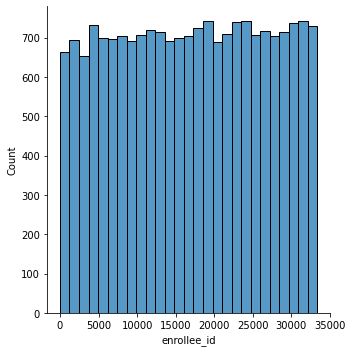

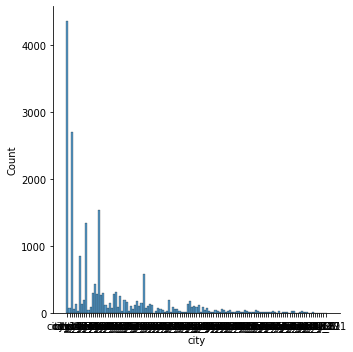

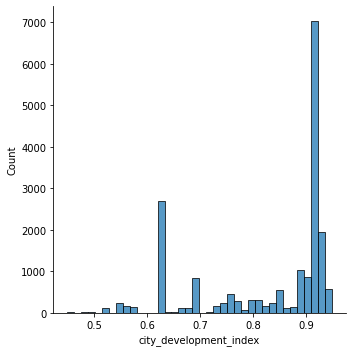

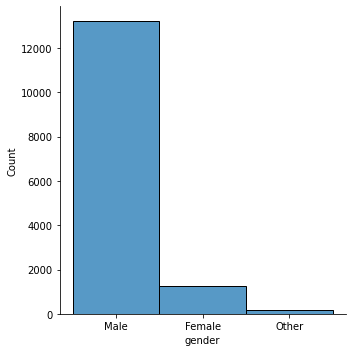

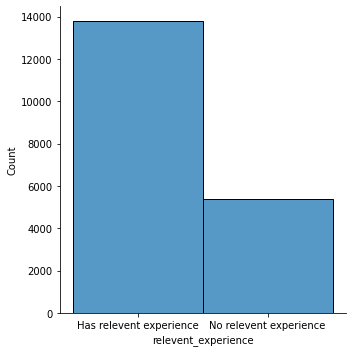

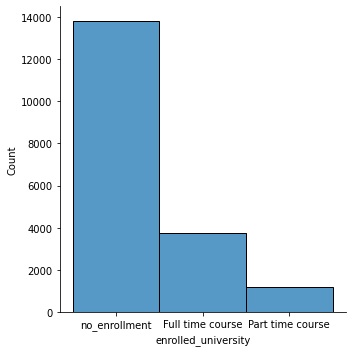

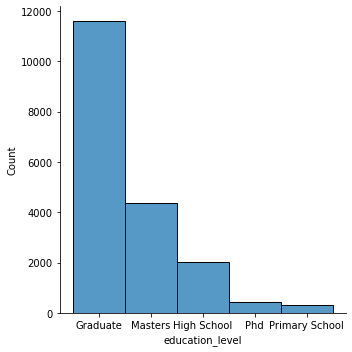

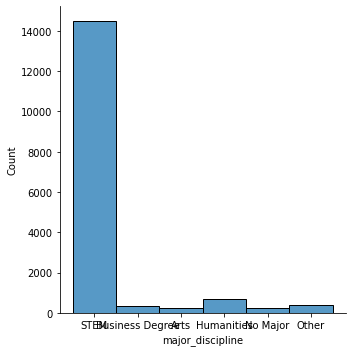

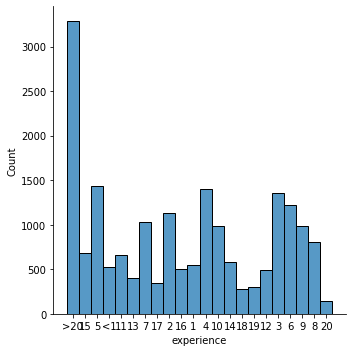

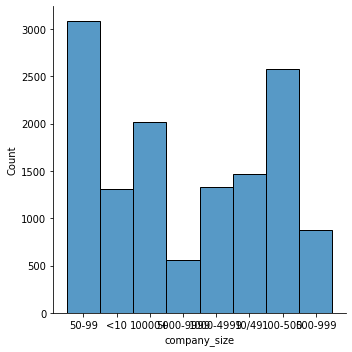

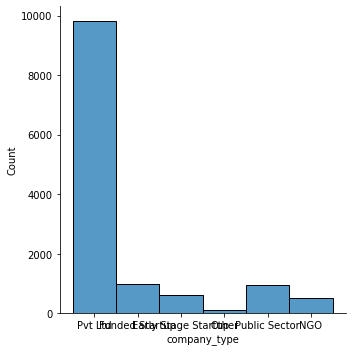

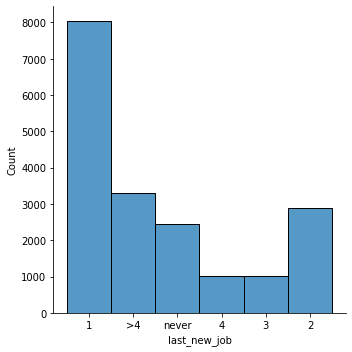

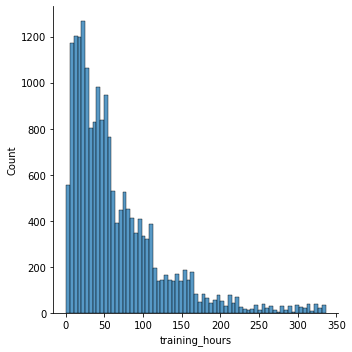

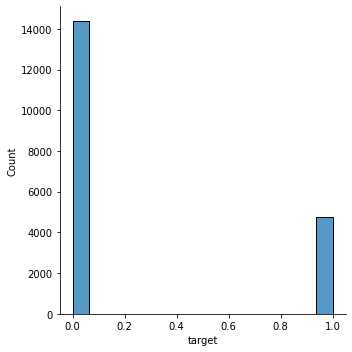

In [28]:
# I want to have a closer look to the data. Unbalanced data for almost all columns. Most of the candidates seem to 
# not want to change the company after the training. The most training hours needed was between 0-100h. 

for col in df:
    sns.displot(df[col])
    plt.show()

In [31]:
len(df[(df['training_hours'] > 0) & (df['training_hours'] < 100)]), len(df[df['training_hours'] >= 100])

(15177, 3981)

## Data Cleaning

In [7]:
nulls = pd.DataFrame(df.isna().sum()*100/len(df), columns=['percentage'])
nulls.sort_values('percentage', ascending = False).head(80)

,percentage
company_type,32.049274
company_size,30.994885
gender,23.530640
major_discipline,14.683161
education_level,2.401086
last_new_job,2.207955
enrolled_university,2.014824
experience,0.339284
enrollee_id,0.000000
city,0.000000


In [12]:
#1. Function to impute null value with new category
def impute_nan_create_category(df,ColName):
     df[ColName] = np.where(df[ColName].isnull(),"Unknown",df[ColName])

## Call function to create new category for variables
for Columns in ['education_level','company_type','gender','major_discipline','enrolled_university', 'experience']:
    impute_nan_create_category(df,Columns)

#2. Display result
df[['education_level','company_type','company_size','gender','major_discipline','last_new_job','enrolled_university', 'experience']].head(10)

,education_level,company_type,company_size,gender,major_discipline,last_new_job,enrolled_university,experience
0,Graduate,Unknown,Unknown,Male,STEM,1,no_enrollment,>20
1,Graduate,Pvt Ltd,50-99,Male,STEM,>4,no_enrollment,15
2,Graduate,Unknown,Unknown,Unknown,STEM,never,Full time course,5
3,Graduate,Pvt Ltd,Unknown,Unknown,Business Degree,never,Unknown,<1
4,Masters,Funded Startup,50-99,Male,STEM,4,no_enrollment,>20
5,Graduate,Unknown,Unknown,Unknown,STEM,1,Part time course,11
6,High School,Funded Startup,50-99,Male,Unknown,1,no_enrollment,5
7,Graduate,Pvt Ltd,<10,Male,STEM,>4,no_enrollment,13
8,Graduate,Pvt Ltd,50-99,Male,STEM,1,no_enrollment,7
9,Graduate,Pvt Ltd,10000+,Unknown,STEM,>4,no_enrollment,17


In [11]:
df.isnull().values.any()

False

In [36]:
df.set_index('enrollee_id')
# Should i drop it?

,city,city_development_index,gender,relevent_experience,enrolled_university,education_level,major_discipline,experience,company_size,company_type,last_new_job,training_hours,target
enrollee_id,,,,,,,,,,,,,
8949,city_103,0.920,Male,Has relevent experience,no_enrollment,Graduate,STEM,>20,NaN,NaN,1,36,1.0
29725,city_40,0.776,Male,No relevent experience,no_enrollment,Graduate,STEM,15,50-99,Pvt Ltd,>4,47,0.0
11561,city_21,0.624,NaN,No relevent experience,Full time course,Graduate,STEM,5,NaN,NaN,never,83,0.0
33241,city_115,0.789,NaN,No relevent experience,NaN,Graduate,Business Degree,<1,NaN,Pvt Ltd,never,52,1.0
666,city_162,0.767,Male,Has relevent experience,no_enrollment,Masters,STEM,>20,50-99,Funded Startup,4,8,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
7386,city_173,0.878,Male,No relevent experience,no_enrollment,Graduate,Humanities,14,NaN,NaN,1,42,1.0
31398,city_103,0.920,Male,Has relevent experience,no_enrollment,Graduate,STEM,14,NaN,NaN,4,52,1.0
24576,city_103,0.920,Male,Has relevent experience,no_enrollment,Graduate,STEM,>20,50-99,Pvt Ltd,4,44,0.0


In [10]:
# Some categorical should be changed into numericals: 
# 'relevent_experience', 'experience', 'company_size', 'last_new_job'
#df['education_level'].unique()
# Should i extract these to small, medium, hudge or change to numerical? How to deal with values like >1

In [38]:
dfcat = df.select_dtypes(object)
dfnum = df.select_dtypes(np.number)

In [40]:
# encoding categorical
df = pd.get_dummies(df, drop_first=True) 
df

,enrollee_id,city_development_index,training_hours,target,city_city_10,city_city_100,city_city_101,city_city_102,city_city_103,city_city_104,...,company_type_Funded Startup,company_type_NGO,company_type_Other,company_type_Public Sector,company_type_Pvt Ltd,last_new_job_2,last_new_job_3,last_new_job_4,last_new_job_>4,last_new_job_never
0,8949,0.920,36,1.0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
1,29725,0.776,47,0.0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,1,0
2,11561,0.624,83,0.0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
3,33241,0.789,52,1.0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,1
4,666,0.767,8,0.0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19153,7386,0.878,42,1.0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
19154,31398,0.920,52,1.0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,1,0,0
19155,24576,0.920,44,0.0,0,0,0,0,1,0,...,0,0,0,0,1,0,0,1,0,0
19156,5756,0.802,97,0.0,0,0,0,0,0,0,...,0,0,0,0,1,1,0,0,0,0


## Binary Classification Model